# Import Required Libraries
Import the necessary libraries, including NumPy, pandas, and sklearn.

In [9]:
# Importing the required libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt


# Define the Move-Split-Merge (MSM) Distance
Define a function to calculate the MSM distance between two time series.

In [4]:
def C(xi, x_prev, yj, c):
    if x_prev <= xi <= yj or x_prev >= xi >= yj:
        return c  # move is the best option
    else:
        return c + min(abs(xi - x_prev), abs(xi - yj))

def MSM_Distance(X, Y, c=0.1, verbose=False, return_cost=False):
    """
    Calculate the Move-Split-Merge (MSM) distance between two time series.
    Parameters:
    X (np.array): The first time series.
    Y (np.array): The second time series.
    c (float): The cost of the operations (move). Default is 0.1.
    return__cost (bool): If True, return the cost matrix. Default is False.
    verbose (bool): If True, log the operations. Default is False.
    Returns:
    tuple: The MSM distance between the two time series.
    """
    m = len(X)
    n = len(Y)
    Cost = np.zeros((m, n))

    # Initialization
    Cost[0, 0] = abs(X[0] - Y[0])
    if verbose:
        print(f"Init: Cost[0,0] = |{X[0]} - {Y[0]}| = {Cost[0, 0]}")

    for i in range(1, m):
        Cost[i, 0] = Cost[i - 1, 0] + C(X[i], X[i - 1], Y[0], c)
        if verbose:
            print((f"Init: Cost[{i},0] = Cost[{i - 1},0] + C({X[i]},"
                   f"{X[i - 1]}, {Y[0]}, {c}) = {Cost[i, 0]}"))

    for j in range(1, n):
        Cost[0, j] = Cost[0, j - 1] + C(Y[j], Y[j - 1], X[0], c)
        if verbose:
            print((f"Init: Cost[0,{j}] = Cost[0,{j - 1}] + C({Y[j]},"
                   f"{Y[j - 1]}, {X[0]}, {c}) = {Cost[0, j]}"))

    # Main Loop
    for i in range(1, m):
        for j in range(1, n):
            # diagonal movement in the cost matrix. This operation considers
            # the cost of matching the ith element in the time series X with
            # the jth element in Y.
            move_cost = Cost[i - 1, j - 1] + abs(X[i] - Y[j])

            # vertical movement in the cost matrix. This operation considers
            # the cost of potentially merging the ith element in the time
            # series X with the (i−1)th element before matching it with the
            # jth element in Y.
            merge_cost = Cost[i - 1, j] + C(X[i], X[i - 1], Y[j], c)

            # horizontal movement in the cost matrix. This operation accounts
            # for the cost of potentially splitting the jth element in the
            # time series Y to align with the ith element in X.
            split_cost = Cost[i, j - 1] + C(Y[j], X[i], Y[j - 1], c)

            Cost[i,j] = min(move_cost, merge_cost, split_cost)

            if verbose:
                print(
                    (f"Cost[{i},{j}]:  min(Move: "
                     f"{move_cost}, Merge: {merge_cost}, Split: "
                     f"{split_cost}) = {Cost[i, j]}")
                )

    if return_cost:
        return Cost[-1, -1], Cost
    else:
        return Cost[-1, -1]

In [13]:
# Example usage:
X = [0.5, 1, 2, -1, -1.5, -1, -0.2, 1.5, 2, 2.5]  # Example time series X
Y = [0, -0.5, -1, 0, 0.5, 0.5, 0, 0, 0.5, 3]  # Example time series Y
c = 1  # Cost parameter

distance, cost_matrix = MSM_Distance(X, Y, c, return_cost=True, verbose=False)
print(f"X: {X}")
print(f"Y: {Y}")
print("The MSM distance is:", distance)
print("The cost matrix is:\n", cost_matrix)

X: [0.5, 1, 2, -1, -1.5, -1, -0.2, 1.5, 2, 2.5]
Y: [0, -0.5, -1, 0, 0.5, 0.5, 0, 0, 0.5, 3]
The MSM distance is: 11.7
The cost matrix is:
 [[ 0.5  2.   3.5  4.5  5.5  6.5  8.   9.  10.  13.5]
 [ 2.   2.   3.5  4.5  5.   6.   7.5  8.5  9.5 12. ]
 [ 4.   4.   5.   5.5  6.   6.5  8.   9.  10.  10.5]
 [ 6.   4.5  4.   6.   7.   7.5  7.5  8.5 10.  13.5]
 [ 7.5  6.   5.   5.5  7.   8.   9.   9.  10.5 14. ]
 [ 8.5  7.   6.   6.   7.   8.   9.  10.  10.5 14. ]
 [ 9.5  8.3  7.8  6.2  6.7  7.7  8.2  9.2 10.7 13.7]
 [12.  11.  10.5  8.7  7.2  7.7  9.2  9.7 10.2 12.2]
 [13.5 12.5 12.  10.2  8.7  8.7  9.7 10.7 11.2 11.2]
 [15.  14.  13.5 11.7 10.2 10.2 11.2 12.2 12.7 11.7]]


In [10]:
def compute_path(cost_matrix):
    n, m = cost_matrix.shape
    alignment = []
    i, j = n - 1, m - 1
    
    while i > 0 or j > 0:
        alignment.append((i, j))
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            min_index = np.argmin((cost_matrix[i-1, j-1], cost_matrix[i-1, j], cost_matrix[i, j-1]))
            if min_index == 0:
                i -= 1
                j -= 1
            elif min_index == 1:
                i -= 1
            else:
                j -= 1
    
    alignment.append((0, 0))
    return list(reversed(alignment))

/tmp/ipykernel_49812/186713200.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


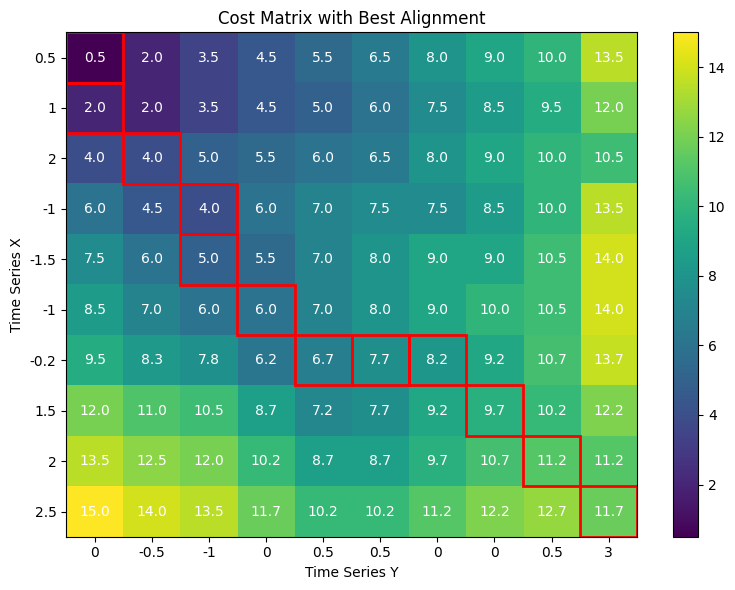

In [11]:
def plot_cost_matrix(cost_matrix, alignment, X, Y):
    n, m = cost_matrix.shape
    
    # Create a color map for the cost matrix
    cmap = plt.cm.get_cmap('viridis')
    
    # Plot the cost matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cost_matrix, cmap=cmap, aspect='auto')
    
    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_label('Cost')
    
    # Add labels and title
    ax.set_xticks(np.arange(m))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(Y)
    ax.set_yticklabels(X)
    ax.set_xlabel('Time Series Y')
    ax.set_ylabel('Time Series X')
    ax.set_title('Cost Matrix with Best Alignment')
    
    # Highlight the best alignment path
    for i, j in alignment:
        ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='red', lw=2))
    
    # Add cost matrix values to each cell
    for i in range(n):
        for j in range(m):
            ax.text(j, i, round(cost_matrix[i, j], 2), ha="center", va="center", color="w")
    
    plt.tight_layout()
    plt.show()

_, cost_matrix = MSM_Distance(X, Y, c, return_cost=True, verbose=False)
alignment = compute_path(cost_matrix)

plot_cost_matrix(cost_matrix, alignment, X, Y)

In [12]:
# Test
alignment = compute_path(cost_matrix)
print("The alignment is:", alignment)
# Print the alignment as a matrix
alignment_matrix = np.zeros((len(X), len(Y)))
for i, j in alignment:
    alignment_matrix[i, j] = 1
print("The alignment matrix is:\n", alignment_matrix)

The alignment is: [(0, 0), (1, 0), (2, 1), (3, 2), (4, 2), (5, 3), (6, 4), (6, 5), (6, 6), (7, 7), (8, 8), (9, 9)]
The alignment matrix is:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Barycenter Averaging
The `barycenter_average_msm` function calculates the barycenter average of a set of time series using the Move-Split-Merge (MSM) distance. The barycenter average is an iterative process that updates the center time series by aligning and averaging the input time series until convergence or a maximum number of iterations is reached.


In [14]:
def msm_barycenter_average(X, max_iters=30, c=1.0, tol=1e-5, verbose=False):
    center = msm_medoids(X, c)
    prev_cost = np.inf
    
    for i in range(max_iters):
        center, cost = msm_ba_update(center, X, c, verbose)
        if verbose:
            print(f"Iteration {i+1}: Cost = {cost}")
        
        if abs(prev_cost - cost) < tol:
            if verbose:
                print(f"Convergence reached at iteration {i+1}")
            break
        
        prev_cost = cost
    
    return center

def msm_ba_update(center, X, c, verbose=False):
    n, m = X.shape[0], center.shape[0]
    num_warps = np.zeros(m)
    alignment = np.zeros(m)
    total_cost = 0
    
    for i in range(n):
        dist, cost_matrix = MSM_Distance(X[i], center, c, return_cost=True)
        curr_alignment = compute_path(cost_matrix)
        for j, k in curr_alignment:
            alignment[k] += X[i, j]
            num_warps[k] += 1
        total_cost += dist
    
    new_center = alignment / num_warps
    avg_cost = total_cost / n
    
    if verbose:
        print(f"Average cost: {avg_cost}")
    
    return new_center, avg_cost

def msm_medoids(X, c):
    n = X.shape[0]
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = MSM_Distance(X[i], X[j], c)
    
    medoid_index = np.argmin(np.sum(dist_matrix, axis=1))
    return X[medoid_index]

In [15]:
# Example usage:
X = np.array([[1, 3, 4, 9, 8], [1, 5, 3, 8, 7]])  # Example time series dataset
c = 1  # Cost parameter
barycenter = msm_barycenter_average(X, c=c)
print(f"The barycenter average time series is: {barycenter}")

The barycenter average time series is: [1.  4.  3.5 8.5 7.5]


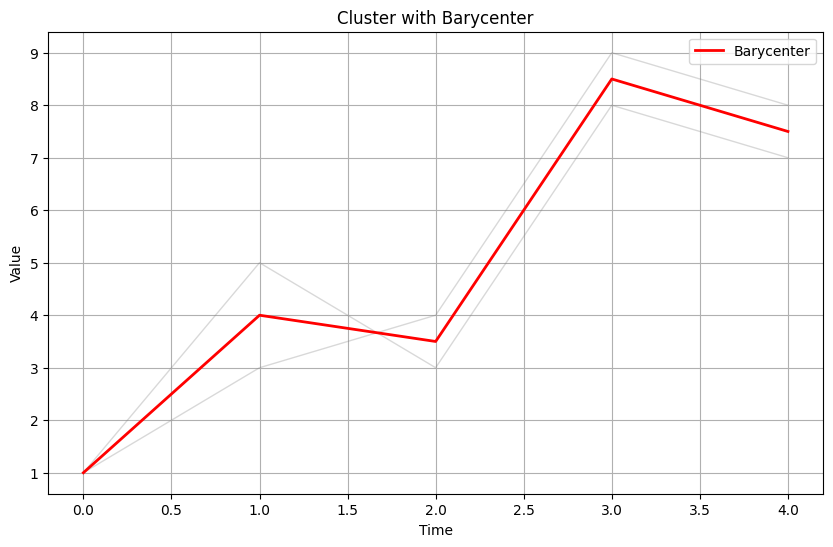

In [16]:
def plot_cluster_with_barycenter(X, barycenter):
    plt.figure(figsize=(10, 6))
    
    # Plot the individual time series in the cluster
    for ts in X:
        plt.plot(ts, color='gray', alpha=0.3, linewidth=1)
    
    # Plot the barycenter time series with a thicker line and higher opacity
    plt.plot(barycenter, color='red', alpha=1.0, linewidth=2, label='Barycenter')
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Cluster with Barycenter')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_cluster_with_barycenter(X, barycenter)


# Create a Time Series Dataset
Create a synthetic time series dataset for the purpose of this notebook.

Data shape (n_samples, n_features, n_timesteps): (100, 1, 50)
Cluster labels (y): [1 0 2 1 0 2 2 2 0 2 2 1 0 1 2 0 0 1 0 1 0 1 1 1 0 0 2 2 2 0 2 1 0 0 2 2 1
 1 1 0 1 2 0 2 0 2 2 1 0 1 1 1 0 1 1 2 2 0 2 0 1 2 1 0 0 0 2 2 0 0 1 2 1 1
 2 2 0 2 2 2 2 0 0 2 0 1 0 1 2 0 1 2 0 0 1 1 1 1 1 0]


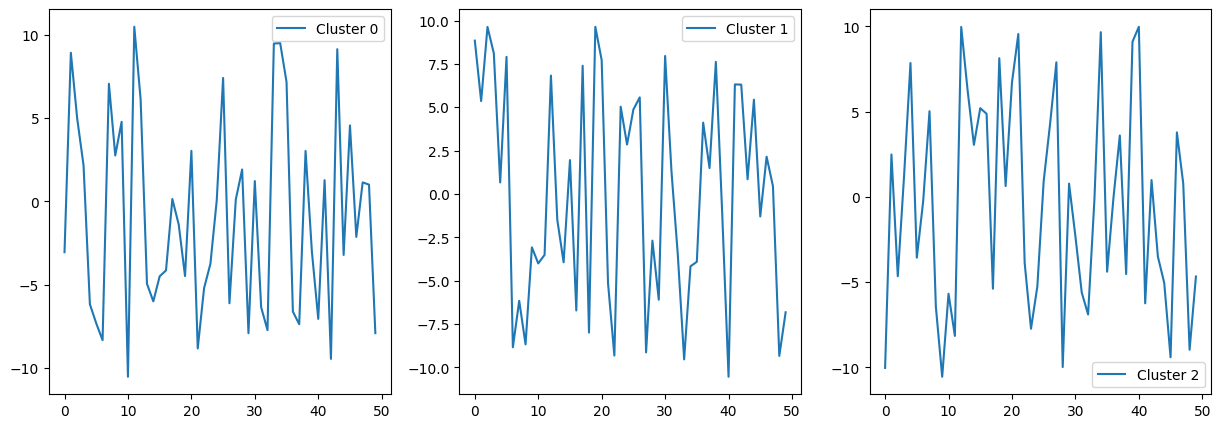

In [18]:
from sklearn.datasets import make_blobs

n_samples = 100
n_clusters = 3
n_timesteps = 50

# Generate synthetic data using make_blobs
X, clusters = make_blobs(n_samples=n_samples, centers=3, n_features=n_timesteps, random_state=42)

# Reshape the data to represent time series
X = X.reshape(n_samples, 1, n_timesteps)

print("Data shape (n_samples, n_features, n_timesteps):", X.shape)
print("Cluster labels (y):", clusters)

# Plot one time series from each cluster
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(n_clusters):
    axs[i].plot(X[clusters == i][0].ravel(), label=f"Cluster {i}")
    axs[i].legend()
plt.show()

# Apply MSM Distance to Time Series Dataset
Apply the MSM distance function to the time series dataset to create a distance matrix.

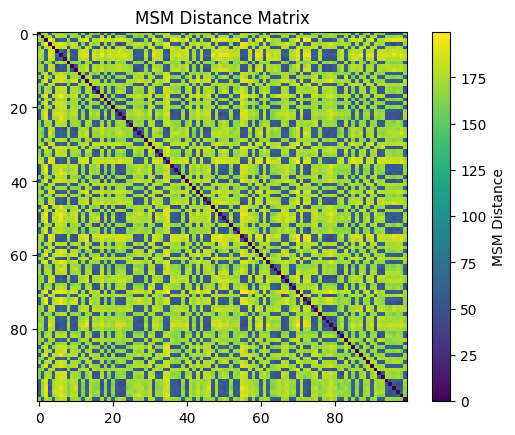

In [19]:
# Apply MSM Distance to Time Series Dataset
# Create an empty matrix to store the MSM distances
msm_distance_matrix = np.zeros((n_samples, n_samples))

# Calculate the MSM distance between each pair of time series
for i in range(n_samples):
    for j in range(n_samples):
        msm_distance_matrix[i, j] = MSM_Distance(X[i].ravel(), X[j].ravel(), c=1)

# Plot the MSM distance matrix
plt.imshow(msm_distance_matrix, cmap="viridis")
plt.colorbar(label="MSM Distance")
plt.title("MSM Distance Matrix")
plt.show()

# Implement K-means Clustering
Implement the K-means clustering algorithm from scratch.

In [25]:
from sklearn.cluster import KMeans

In [29]:
foo = KMeans(3, random_state=42).fit_predict(msm_distance_matrix)

/home/victor/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [34]:
clusters

array([1, 0, 2, 1, 0, 2, 2, 2, 0, 2, 2, 1, 0, 1, 2, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 2, 2, 2, 0, 2, 1, 0, 0, 2, 2, 1, 1, 1, 0, 1, 2, 0, 2,
       0, 2, 2, 1, 0, 1, 1, 1, 0, 1, 1, 2, 2, 0, 2, 0, 1, 2, 1, 0, 0, 0,
       2, 2, 0, 0, 1, 2, 1, 1, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 1, 0, 1,
       2, 0, 1, 2, 0, 0, 1, 1, 1, 1, 1, 0])

In [33]:
print(f"Clustering accuracy: {accuracy_score(clusters, foo):.2f}")

Clustering accuracy: 0.00


In [20]:
# Define K-means Clustering
def k_means_clustering(data, k, max_iters=100, tol=1e-5, verbose=False):
    """
    Implement the K-means clustering algorithm from scratch.
    
    Parameters:
    data (np.array): The data to be clustered.
    k (int): The number of clusters.
    max_iters (int): The maximum number of iterations. Default is 100.
    tol (float): The tolerance to declare convergence. Default is 1e-5.
    verbose (bool): If True, log the iterations. Default is False.
    
    Returns:
    np.array: The cluster labels for each data point.
    np.array: The cluster centroids.
    float: The inertia or the sum of squared distances of samples to their closest cluster center.
    """
    # Initialize the centroids randomly from the data points.
    centroids = data[np.random.choice(range(data.shape[0]), size=k, replace=False)]
    
    for _ in range(max_iters):
        # Assign each data point to the closest centroid.
        labels = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)
        
        # Calculate the new centroids with the barycenter of the data points in each cluster.
        new_centroids = np.array([msm_barycenter_average(data[labels == i]) for i in range(k)])

        # Inertia or the sum of squared distacentroidsnces of samples to their closest cluster center
        inertia = np.sum((data - centroids[labels]) ** 2)
        
        # If the centroids have not changed, then the algorithm has converged.
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        
        centroids = new_centroids
    
    return labels, centroids, inertia

In [21]:
# Test the K-means clustering algorithm with toy data
n_clusters = 3
foo = np.array([[1, 3, 4, 9, 8], [1, 5, 3, 8, 7], [2, 4, 5, 10, 9], [2, 6, 4, 9, 8]])
labels, centroids, inertia = k_means_clustering(foo, n_clusters, verbose=True)

print("Cluster labels:", labels)
print("Cluster centroids\n:", centroids)
print("Inertia:", inertia)

Cluster labels: [0 1 2 1]
Cluster centroids
: [[ 1.   3.   4.   9.   8. ]
 [ 1.5  5.5  3.5  8.5  7.5]
 [ 2.   4.   5.  10.   9. ]]
Inertia: 2.5


# Apply K-means Clustering to Time Series Dataset
Apply the K-means clustering algorithm to the time series dataset using the MSM distance.

In [23]:
# Apply K-means Clustering to Time Series Dataset
n_clusters = 3
labels, centroids, inertia = k_means_clustering(X.reshape(n_samples, n_timesteps), n_clusters)
print(f"Clustering accuracy: {accuracy_score(clusters, labels):.2f}")

Clustering accuracy: 0.00


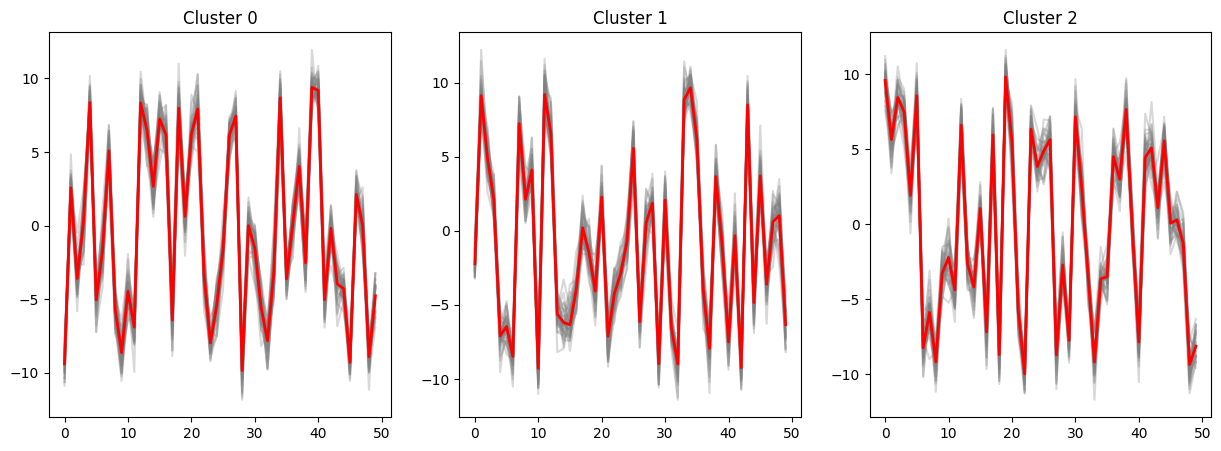

In [24]:
# Plot the clustered time series for each cluster, in separate subplots
fig, axs = plt.subplots(1, n_clusters, figsize=(15, 5))

for i in range(n_clusters):
    axs[i].plot(X.reshape(n_samples, n_timesteps)[labels == i].T, color='gray', alpha=0.3)
    axs[i].plot(centroids[i], color='red', alpha=1.0, linewidth=2)
    axs[i].set_title(f"Cluster {i}")
plt.show()